# Image Classification with the Medical MNIST Dataset

**Sources:**

https://medmnist.com/

https://github.com/MedMNIST/MedMNIST

---

Copyright statement:
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

So far, we dived into the basics of Python, PyTorch, `autograd` and how to create and train neural networks. In the last notebooks, we have looked at a so-called Multi-Layer-Perceptron, a deep neural network consisting or linear layers and activation functions. In this notebook we will look at another class of neural network architectures - a Convolutional Neural Network (CNN). CNN's are commonly used for various image-related tasks, such as classifying an image, segmenting objects in an image etc. In this notebook, we will focus on classifying skin lesions from the publicly available `DermaMNIST` dataset.

## The Medical MNIST Dataset

MedMNIST is a large-scale MIST-like collection of biomedical images, sorted into 18 pre-processed datasets: 12 for 2D (e.g. retina, dermal, tissue etc.) with ~708K images, and 6 for 3D (e.g. organs, fractures etc.) with ~10K images. MedMNIST is designed for performing image classification in various settings (binary/multiclass, ordinal regression, multi-label), supporting numerous research and educational purposes in biomedical image analysis. Similarly to the MNIST dataset of handwritten digits, MedMNIST images are resized to 28x28 resolution, though larger variants up to 224x224 are available. More information about the MedMNIST dataset is given under the "Sources" above. Here are some snippets of what MedMNIST contains:

![Datasets in MedMNIST](https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/assets/medmnistv2.jpg)

## The Task

In this notebook, you will work with the 2D DermaMNIST sub-dataset, which consists of ~10K images of skin lesions (area of your skin that is abnormal from the skin around it), catregorized into 7 classes. The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images. You will work out a simple multi-class image classification pipeline where your model maps an image of a skin lesion to one of the 7 classes.

## Setup

First, make sure to mount your Google Drive in case you are running this notebook on Google Colab. This makes sure that any downloaded or saved data is easily accessible to you while running the notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


MedMNIST requires some Python packages, so let's make sure they are installed. Any packages that are needed in this notebook (e.g. torchvision) are also installed.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Next, we install MedMNIST and check the version:

In [2]:
!pip install medmnist
import medmnist

In [3]:
print(medmnist.__version__)

3.0.2


Finally, we import the DermaMNIST subset such that we can work with it:

In [4]:
from medmnist import DermaMNIST, Evaluator, INFO

Looking at the `INFO` dictionary gives us useful information about the dataset in general. This is true for all MedMNIST subsets.

In [5]:
INFO['dermamnist']

{'python_class': 'DermaMNIST',
 'description': 'The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/dermamnist.npz?download=1',
 'MD5': '0744692d530f8e62ec473284d019b0c7',
 'url_64': 'https://zenodo.org/records/10519652/files/dermamnist_64.npz?download=1',
 'MD5_64': 'b70a2f5635c6199aeaa28c31d7202e1f',
 'url_128': 'https://zenodo.org/records/10519652/files/dermamnist_128.npz?download=1',
 'MD5_128': '2defd784463fa5243564e855ed717de1',
 'url_224': 'https://zenodo.org/records/10519652/files/dermamnist_224.npz?download=1',
 'MD5_224': '8974907d8e169bef5f5b96bc506ae45d',
 'task': 'multi-c

We can also observe the unique skin lesion labels as well as the number of channels (3 for RGB):

In [6]:
print('Labels:')
INFO['dermamnist']['label']

Labels:


{'0': 'actinic keratoses and intraepithelial carcinoma',
 '1': 'basal cell carcinoma',
 '2': 'benign keratosis-like lesions',
 '3': 'dermatofibroma',
 '4': 'melanoma',
 '5': 'melanocytic nevi',
 '6': 'vascular lesions'}

In [7]:
print('Channels:', INFO['dermamnist']['n_channels'])

Channels: 3


Lastly for the setup, we specify our device (cpu or gpu) that we will train our model on:

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))

Device: cuda


## DermaMNIST pre-processing

First, the data is downloaded and split into train-val-test sets in a 70-10-20% fashion. So-called image/data transforms are applied to augment the data. Data augmentation is useful for avoiding overfitting and introducing more robustness and invariance against changes in the input. The subsets are packaged into their respective `DataLoader`'s for easier data bacthing during training and evaluation.

In [9]:
transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[.5], std=[.5])
])

In [10]:
# download, split and package into DataLoaders
train_data = DermaMNIST(split='train', transform=transforms, download=True)
test_data = DermaMNIST(split='test', transform=transforms, download=True)

#define arguments for the dataloaders
BATCH_SIZE=128

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE)

Using downloaded and verified file: /system/user/legat/.medmnist/dermamnist.npz
Using downloaded and verified file: /system/user/legat/.medmnist/dermamnist.npz


We store the 7 possible labels in a dictionary variable for further use:

In [11]:
# inspect unique labels of dataset
class_dict = INFO['dermamnist']['label']
class_dict

{'0': 'actinic keratoses and intraepithelial carcinoma',
 '1': 'basal cell carcinoma',
 '2': 'benign keratosis-like lesions',
 '3': 'dermatofibroma',
 '4': 'melanoma',
 '5': 'melanocytic nevi',
 '6': 'vascular lesions'}

Finally, let's visualize a subset of our DermaMNIST to get a better understanding.

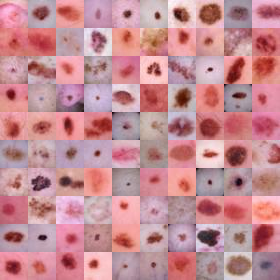

In [12]:
train_data.montage(length=10)

## Image Classification

Similarly to the last notebooks, we follow the structure of creating a Python class for our CNN. You'll notice that the notation here looks slightly different from the previous notebooks, and we also introduce some new concepts here. First off, `nn.Sequential` is a container module provided by PyTorch that lets you stack different modules and layers in a clean and readable way, which is especially useful when your model flows *sequentially* from one layer to the next. `nn.Sequential` takes layers and operations in the order they should be executed, separated by commas, and feeds the output of one component as input to the next.

We also encounter some new concepts:

*   **Convolutional layers:** This is the main building block of a CNN. It slides a filter/kernel/"window" of a certain height and width over the input image and extracts features (e.g. corners, edges etc) from it that way. These filters are learnable and slide across the input with a certain stride, performing element-wise multiplication and summation afterwards. The resulting output is called a **feature map**
*   **Batch Normalization:** Normalizes the activations of a layer within the current batch during training. This helps against distribution shift and fosters stable learning
*   **Max Pooling:** This operation reduces the size of the input or feature map by taking the maximum value within a small (e.g. 2x2) window. This helps to preserve the most prominent features no matter where exactly they occur, while also downsampling the input/feature map
*   **Dropout:** Randomly sets certain neurons to zero during training in order to prevent overfitting and improve the model's ability to generalize by teaching it not to depend on certain singular neurons too much

In [13]:
class DermaClf(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(DermaClf, self).__init__()

    # 5 sequential convolutionsl layers
    self.layer1 = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3),
                                    nn.BatchNorm2d(16), nn.ReLU())

    self.layer2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
                                    nn.BatchNorm2d(32), nn.ReLU())

    self.layer3 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    nn.BatchNorm2d(64), nn.ReLU())

    self.layer4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                                    nn.BatchNorm2d(64), nn.ReLU())

    # max pooling layer added
    self.layer5 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(64), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
    # add two fully connected layers
    self.fc = nn.Sequential(nn.Linear(64 * 10 * 10, out_features=512),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(in_features=512, out_features=num_classes))

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)

    x = torch.flatten(x, 1)

    x = self.fc(x)
    return x

model = DermaClf(in_channels=3, num_classes=7)
print(model)

DermaClf(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(

We print our model size, i.e. the total number of parameters. It is always useful to keep track of this, especially when working within hardware constraints:

In [14]:
print('Numer of parameters: ', sum([torch.numel(p) for p in model.parameters()]))

Numer of parameters:  3378823


Next, we define our training and evaluation loop similar to what we did in past notebooks. This time, we define them encapsulated as functions. This is practical in case you want to start your training loop from any cell.

In [15]:
def train(model, train_loader, optimizer, device, criterion):
    model.train()
    model = model.to(device)

    losses = []
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device) # push to gpu

        optimizer.zero_grad()
        preds = model(inputs)
        targets = torch.squeeze(targets).to(device) # remove empty dim

        loss = criterion(preds, targets)

        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    total += targets.shape[0]
    correct += torch.sum(preds.max(1)[1] == targets).item()

    return {
        'train_acc': f'{np.round(correct / total, 3):.3f}',
        'train_loss': f'{np.round(np.mean(losses), 3):.3f}',
    }


def evaluate(model, test_loader, device, criterion):
    model.eval()
    model = model.to(device)

    losses = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            preds = model(inputs)

            targets = torch.squeeze(targets).to(device)
            loss = criterion(preds, targets)

            losses.append(loss.item())
            total += targets.shape[0]
            correct += (preds.max(1)[1] == targets).sum().cpu().numpy()

        return {
            'test_acc': f'{np.round(correct / total, 3):.3f}',
            'test_loss': f'{np.round(np.mean(losses), 3):.3f}',
        }

Next, we define some settings and run our train-eval loop. For multi-class classification problems, we choose the Cross Entropy Loss, as well as the Adam optimizer with a learning rate of 0.0001

In [16]:
n_epochs = 10 # feel free to play around with this value
criterion = nn.CrossEntropyLoss() # loss function for multi-class problems
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in tqdm(range(n_epochs)):
  train_history = train(model=model, train_loader=train_loader, optimizer=optimizer, device=device, criterion=criterion)
  eval_history = evaluate(model=model, test_loader=test_loader, device=device, criterion=criterion)

  print(f'\n Epoch {epoch}, Train set stats: {train_history}, Test set stats: {eval_history}')

 10%|█         | 1/10 [00:05<00:52,  5.78s/it]


 Epoch 0, Train set stats: {'train_acc': '0.737', 'train_loss': '0.985'}, Test set stats: {'test_acc': '0.704', 'test_loss': '0.826'}


 20%|██        | 2/10 [00:07<00:27,  3.46s/it]


 Epoch 1, Train set stats: {'train_acc': '0.737', 'train_loss': '0.811'}, Test set stats: {'test_acc': '0.716', 'test_loss': '0.775'}


 30%|███       | 3/10 [00:09<00:18,  2.71s/it]


 Epoch 2, Train set stats: {'train_acc': '0.747', 'train_loss': '0.766'}, Test set stats: {'test_acc': '0.722', 'test_loss': '0.751'}


 40%|████      | 4/10 [00:11<00:14,  2.36s/it]


 Epoch 3, Train set stats: {'train_acc': '0.737', 'train_loss': '0.725'}, Test set stats: {'test_acc': '0.728', 'test_loss': '0.740'}


 50%|█████     | 5/10 [00:13<00:10,  2.17s/it]


 Epoch 4, Train set stats: {'train_acc': '0.768', 'train_loss': '0.690'}, Test set stats: {'test_acc': '0.743', 'test_loss': '0.704'}


 60%|██████    | 6/10 [00:14<00:08,  2.05s/it]


 Epoch 5, Train set stats: {'train_acc': '0.695', 'train_loss': '0.661'}, Test set stats: {'test_acc': '0.731', 'test_loss': '0.714'}


 70%|███████   | 7/10 [00:16<00:05,  1.98s/it]


 Epoch 6, Train set stats: {'train_acc': '0.800', 'train_loss': '0.629'}, Test set stats: {'test_acc': '0.745', 'test_loss': '0.707'}


 80%|████████  | 8/10 [00:18<00:03,  1.96s/it]


 Epoch 7, Train set stats: {'train_acc': '0.674', 'train_loss': '0.593'}, Test set stats: {'test_acc': '0.736', 'test_loss': '0.689'}


 90%|█████████ | 9/10 [00:20<00:01,  1.95s/it]


 Epoch 8, Train set stats: {'train_acc': '0.821', 'train_loss': '0.563'}, Test set stats: {'test_acc': '0.746', 'test_loss': '0.674'}


100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


 Epoch 9, Train set stats: {'train_acc': '0.842', 'train_loss': '0.528'}, Test set stats: {'test_acc': '0.741', 'test_loss': '0.688'}


### Visualizing predictions

Now that we have a trained model, we can observe how well it predicts skin lesions by looking at an example directly. We choose a random image from the test set, visualize it, as well as feed it to our newly trained CNN and extract the most likely class it predicts the skin lesion to be of.

Before we can visualize anything, we need to unnormalize the image first. This step needs to be done because we used `transforms` before, specifically `v2.Normalize(mean=[.5], std=[.5])`, which does the following operation `img - mean / std`. We also need to permute the dimensions in order for `matplotlib` to work.

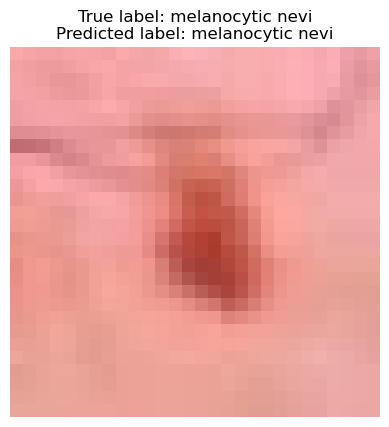

In [18]:
# choose a random image from the test dataset
rand_idx = np.random.randint(0, len(test_data)-1)
img, label = test_data[rand_idx]

# unnormalize for visualization - img * std / mean
vis_img = (img * 0.5) + 0.5
vis_img = vis_img.permute(1,2,0).numpy()

# prepare img for model predictions
pred_img = img.unsqueeze(0).to(device)

# pass img to model and predict
model.eval() # evaluation mode for inference
model = model.to(device)
pred = model(pred_img) # get class probabilities
pred_idx = pred.argmax(dim=1).item() # choose most likely class

# extract class labels from previously defined class dictionary
pred_label = class_dict[str(pred_idx)]
true_label = class_dict[str(label.item())]

plt.imshow(vis_img)
plt.title(f"True label: {true_label}\nPredicted label: {pred_label}")
plt.axis("off")
plt.show()

### Saving the model

If we want to re-use our model for predicting outside of the current notebook, we can save it to our device. In order to save some storage, we only store the so-called `state_dict` of our model.

**What is a `state_dict`?**

In PyTorch, the learnable parameters (i.e. weights and biases) of a model are part of the model's total parameters which we have been printing often after model creation. A `state_dict` is simply a Python dictionary object that maps each layer to its parameter tensor. Note that only layers with learnable parameters (convolutional layers, linear layers, etc.) and registered buffers (batchnorm's running_mean) have entries in the model's state_dict. Optimizer objects (torch.optim) also have a state_dict, which contains information about the optimizer's state, as well as the hyperparameters used. The optimizer's `state_dict` should be saved separately in case you want to continue training later. Since we plan on only use it in inference/prediction mode, saving only the model's `state_dict` is enough.

In [19]:
model.eval() # imporant if model should later be used for inference
model.cpu()  # move model to cpu to load it anywhere
torch.save(model.state_dict(), '../output/dermamnist_clf.pt')